In [5]:
import os
import cv2
import inspect
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

os.chdir(r'/RG/rg-tal/orlev/Face-Recognition-Of-Masked-Faces')

from config_file import *
from helpers import get_model, read_images, get_1id_pose, resize_image, img_output_bbox, project_3d,head3d_z_dist, scale_int_array,max_connected_component
from create_masks import masks_templates, load_3dmm, get_frontal, morphological_op, add_forehead_mask,extend_mask

In [3]:
# img_src = '/RG/rg-tal/orlev/datasets/original_ds/lfw/Pierre_Gagnon/Pierre_Gagnon_0001.jpg'
img_src = '/RG/rg-tal/orlev/datasets/original_ds/CASIA-WebFace/0000099/015.jpg'


masks_to_create = masks_templates(ALL_MASKS)


# Get img2pose model
model, transform = get_model()
img = plt.imread(img_src, 1)
results = model.predict([transform(img)])[0]
pose, bbox = get_1id_pose(results, img, 0)

r_img, scale_factor = resize_image(img, bbox)

# output image selected area
output_bbox = img_output_bbox(img, bbox, 0.25, True)

# project 3D face according to pose
df_3dh = project_3d(r_img, pose)
h3d2i = head3d_z_dist(r_img, df_3dh)
mask_name ='eyemask'#masks_to_create[0]
frontal_mask, frontal_add_mask, frontal_rest = get_frontal(r_img, df_3dh, h3d2i, mask_name, scale_factor)
mask_x, mask_y, mask_on_image = morphological_op(True, frontal_mask, img,
                                                 config[mask_name].mask_filter_size, MASK_RIGHT_POINT,
                                                 True, config[mask_name].main_mask_components_number)
bbox_ind = True
f_x, f_y = add_forehead_mask(frontal_mask, frontal_rest, bbox_ind, output_bbox, mask_on_image)
df_3dh_current = df_3dh.copy()
df_top_eyemask = df_3dh_current.iloc[TOP_EYEMASK_INDS]
top_eyemask = df_top_eyemask[~df_top_eyemask['x'].isnull()]
top_eyemask_x = scale_int_array(top_eyemask.x.values, scale_factor)
rel_top = np.where((np.min(top_eyemask_x) <= f_x) & (f_x <= np.max(top_eyemask_x)))

mask_xwf, mask_ywf = np.append(f_x[rel_top], mask_x).astype(int), np.append(f_y[rel_top], mask_y).astype(int)
mask_xywf = np.vstack((mask_xwf, mask_ywf)).T
_, _, mask_on_image_morph = morphological_op(True, mask_xywf, img, EYE_HAT_MASK_LEFT_POINT,
                                   EYE_HAT_MASK_RIGHT_POINT, False, 0)
morph_rest_x, morph_rest_y, rest_on_image = morphological_op(config[mask_name].draw_rest_mask, frontal_rest, img,
                                                 config[mask_name].rest_filter_size, MASK_RIGHT_POINT,
                                                 False, 0, cv2.MORPH_DILATE)
extended_morph_mask = extend_mask(mask_on_image, pose, output_bbox)
extended_morph_rest = extend_mask(rest_on_image, pose, output_bbox)
morph_rest_y, morph_rest_x = np.where(extended_morph_rest.astype(int))

# mask without the extended eye opening
extended_morph_mask = (extended_morph_mask + 2 * extended_morph_rest).astype(int)
np.place(extended_morph_mask, extended_morph_mask != 1, 0)

extended_morph_mask2 = extended_morph_mask.copy()
extended_morph_mask2[morph_rest_y,morph_rest_x] = 0
yy, xx = np.where(extended_morph_mask2 == 1)

Model will use 1 GPUs!


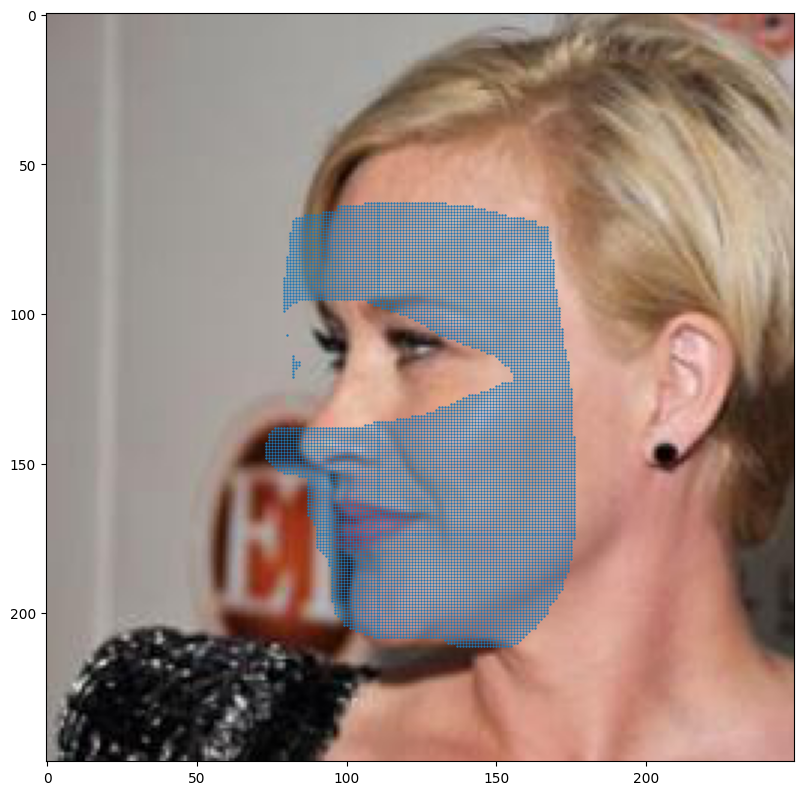

In [10]:
fig1 = plt.figure(figsize=(10, 10),dpi=99.1)
img = plt.imread(img_src, 1)
plt.imshow(img)
plt.scatter(xx, yy, s=0.5,color='C0')

In [11]:
morph_mask_one_component = max_connected_component(extended_morph_mask, True, 1)
morph_mask_y, morph_mask_x = np.where(morph_mask_one_component.astype(int))

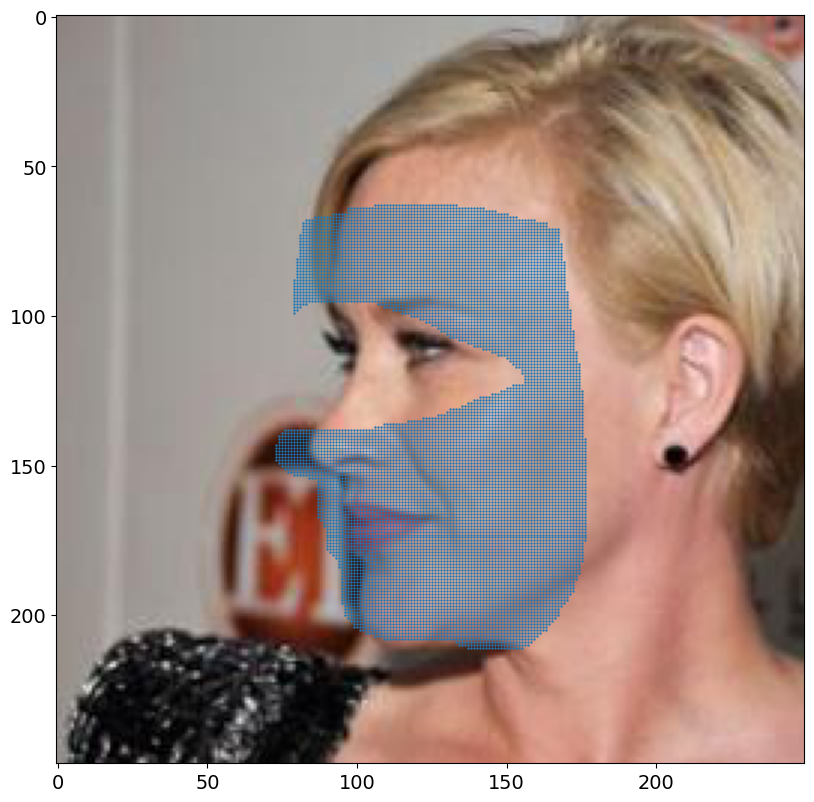

In [13]:
fig1 = plt.figure(figsize=(10, 10),dpi=99.1)
img = plt.imread(img_src, 1)
plt.imshow(img)
plt.scatter(morph_mask_x, morph_mask_y, s=0.5,color='C0')
plt.tick_params(labelsize=14)